In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tools.validation import array_like
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 10)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.float_format = '{:.4f}'.format

# statsmodels.stats.diagnostic.het_white
# Ref: https://www.statsmodels.org/stable/_modules/statsmodels/stats/diagnostic.html#het_white
def het_white(resid, exog):
    x = array_like(exog, "exog", ndim=2)
    y = array_like(resid, "resid", ndim=2, shape=(x.shape[0], 1))
    nobs, nvars0 = x.shape
    i0, i1 = np.triu_indices(nvars0)
    exog = x[:, i0] * x[:, i1]
    nobs, nvars = exog.shape
    assert nvars == nvars0 * (nvars0 - 1) / 2. + nvars0
    resols = sm.OLS(y ** 2, exog).fit()
    fval = resols.fvalue
    fpval = resols.f_pvalue
    lm = nobs * resols.rsquared
    #assert resols.df_model == np.linalg.matrix_rank(exog) - 1 報錯
    lmpval = stats.chi2.sf(lm, resols.df_model)
    return lm, lmpval, fval, fpval

# **1. 試驗一 沒有異質變異的樣本**

利用Put資料，篩選出K=10,000、T介於0.4~0.6、r=0.795%、S介於12,500~13,500的樣本，完成模型一，並利用三種方法檢驗是否有異質變異。

$$C, P = \beta_{0} + \beta_{1} \space S  
 + \beta_{2} \space S^2 $$

**檢驗異質變異方法**
1. 畫殘差圖
2. White Test
3. Breusch-Pagan Test

Ref: https://medium.com/@remycanario17/tests-for-heteroskedasticity-in-python-208a0fdb04ab

In [3]:
# 試驗一 
# X:S S2, Y: Put
dfput = pd.read_csv("TXOPut.csv")
filt1 = dfput.query("K==10000 & S>=12500 & S<=13500 & T > 0.4 & T < 0.6 & r == 0.00795") 

col_list1 = ["S","S2",]  
model = sm.OLS(filt1["Put"], sm.add_constant(filt1[col_list1])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Put   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     35.08
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           7.79e-10
Time:                        17:00:30   Log-Likelihood:                -209.67
No. Observations:                  47   AIC:                             425.3
Df Residuals:                      44   BIC:                             430.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.963e+04   1.25e+04      1.576      0.1

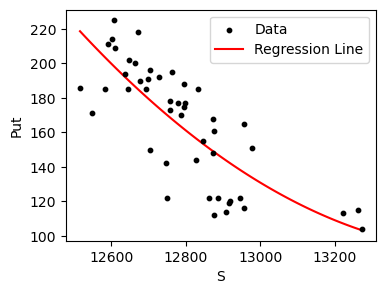

In [4]:
# 2D圖 x軸:S, y軸:Put
x = np.linspace(filt1["S"].min(), filt1["S"].max(), 100)
y = model.params["const"] + model.params["S"] * x  + model.params["S2"] * x**2 

plt.figure(figsize=(4,3))
plt.scatter(filt1["S"], filt1["Put"], label="Data", c='black', s=10, zorder=3)
plt.plot(x, y, "r", label=f'Regression Line')
plt.xlabel("S")
plt.ylabel("Put")
plt.legend()
plt.show()

## 1.1 S v.s. Residuals Plot
繪製S與殘差的散佈圖

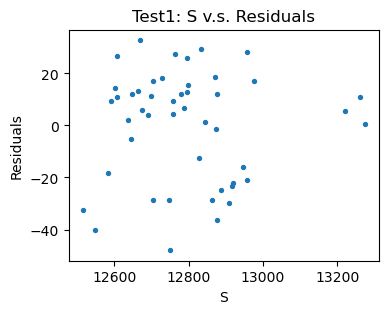

In [5]:
# 1.1. S v.s. Residuals Plot
residuals = model.resid
plt.figure(figsize=(4,3))
plt.scatter(filt1["S"], residuals, s=8)
plt.xlabel("S")
plt.ylabel("Residuals")
plt.title("Test1: S v.s. Residuals")
plt.show()

## 1.2 White Test

In [6]:
_, p_value, _, _ = het_white(model.resid, model.model.exog)
print("p-value: ", p_value)
if p_value < 0.05:
    print("存在異質變異")
else:
    print("不存在異質變異")

p-value:  0.4803118378473743
不存在異質變異


## 1.3 Breusch-Pagan Test

In [7]:
_, p_value, _, _ = het_breuschpagan(model.resid, model.model.exog)
print("p-value: ", p_value)
if p_value < 0.05:
    print("存在異質變異")
else:
    print("不存在異質變異")

p-value:  0.4916539162879897
不存在異質變異


# **2. 試驗二 有異質變異的樣本**
## 2.1 model1 - X: S、S2

利用Put資料，篩選出K=10,000、T介於0.4~0.7、r=0.795%、S介於12,500~14,000的樣本，完成模型一和二，並利用三種方法分別檢驗兩個模型是否有異質變異。

結果是否相同，若無，為什麼?

$$
\begin{align}
   model \space 1: C, P &= \beta_{0} + \beta_{1} S + \beta_{2} S^2  \\
   model \space 2: C, P &= \beta_{0} + \beta_{1} S + \beta_{2} S^2 + \beta_{3} T 
\end{align} 
$$

In [ ]:
# 試驗二 - model 1 
# X:S S2, Y: Put

dfput = pd.read_csv("TXOPut.csv")
filt2 = dfput.query("K==10000 & S>=12500 & S<=14000 & T > 0.4 & T < 0.7 & r == 0.00795") 


In [9]:
# 三種方法檢驗


## 2.2 model2 - X: S、S2、T
與前面2.1一模一樣的樣本，但X多了T進去model

In [ ]:
# 試驗二 - model 2 
# X:S S2 T, Y: Put



In [11]:
# 三種方法檢驗
